In [1]:
#instaliranje potrebne datoteke
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.2 MB/s eta 0:00:00


In [2]:
from Bio import SeqIO
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import math

In [3]:
#spajanje na google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#Funkcija za učitavanje FASTA datoteke
def get_sequences_from_fasta(fasta_file):
    sequences = []
    with open(fasta_file, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            sequences.append(str(record.seq))
    return sequences



In [5]:
#funkcija za generiranje skupa podataka za treniranje i validaciju
data_length=500
korak=100
def getData(fasta_file,gff_file_path,podaci):

    sequence = get_sequences_from_fasta(fasta_file)[0]

    #ucitavanje gff file-a
    columns = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
    GFF_DataFrame = pd.read_csv(gff_file_path, sep="\t", comment="#", names=columns)

    #stvaranje vektora koji određuje da li je baza dio gena ili nije
    gene_vector=tf.zeros(shape=len(sequence))

    for index,row in GFF_DataFrame.iterrows():
        if(row["type"]=="gene"):


            start_position = row["start"]-1
            end_position = row["end"]-1


            mask = tf.concat([
                tf.zeros(start_position),
                tf.ones(end_position - start_position + 1),
                tf.zeros(gene_vector.shape[0] - end_position - 1)
            ], axis=0)


            gene_vector = gene_vector + mask


    gene_vector=gene_vector.numpy()
    for i in range(len(gene_vector)):
        if(gene_vector[i]!=0):
            gene_vector[i]=1
    gene_vector=tf.convert_to_tensor(gene_vector)



    #dijeljenje sekvence na dijelove
    for i in range(math.ceil(len(sequence)/korak)):
        slice_of_seq=sequence[i*korak:i*korak+data_length]
        slice_of_vector=gene_vector[i*korak:i*korak+data_length]

        if(len(slice_of_vector)!=data_length):

            start=(i*korak-len(sequence))
            end=i*korak+data_length-len(sequence)

            #loop around - spaja kraj i pocetak jer je DNA kružna
            slice_of_seq=sequence[start:] + sequence[:end]
            slice_of_vector=tf.concat([gene_vector[start:], gene_vector[:end]], axis=0)

        podaci.append((slice_of_seq,slice_of_vector))
    print("Gotovo sa procesiranjem podataka za bkateriju")
    return podaci


In [6]:
#dohvaćanje podataka sa google drive-a
import os
train_data=[]
val_data=[]
isFirst=True
cwd = os.getcwd()
folder_path = "/content/drive/MyDrive/Gene_annotations"



gene_annotations = os.listdir(folder_path)


for bacteria_name in gene_annotations:

    folder_path="/content/drive/MyDrive" +"/Gene_annotations/"+bacteria_name+"/data"

    files_in_annotations = os.listdir(folder_path)

    for gca_file in files_in_annotations:


        if(gca_file.startswith("GCA")):
            folder_path="/content/drive/MyDrive"+"/Gene_annotations/"+bacteria_name+"/data/"+gca_file

            gca_files = os.listdir(folder_path)

            for file in gca_files:

                if(file.startswith("GCA")):
                    fasta_file="/content/drive/MyDrive/"+"Gene_annotations/"+bacteria_name+"/data/"+gca_file+"/"+file

                if(file=="genomic.gff"):
                    gff_file_path="/content/drive/MyDrive/"+"Gene_annotations/"+bacteria_name+"/data/"+gca_file+"/"+file
    print("\nProcesiranje podataka za "+ bacteria_name+"\n")
    if(isFirst):
      val_data=getData(fasta_file,gff_file_path,val_data)
      isFirst=False
    else:
      train_data=getData(fasta_file,gff_file_path,train_data)







Procesiranje podataka za Mycobacterium_tuberculosis

Gotovo sa procesiranjem podataka za bkateriju

Procesiranje podataka za Staphylococcus_aureus

Gotovo sa procesiranjem podataka za bkateriju

Procesiranje podataka za Lysinibacillus_fusiformis

Gotovo sa procesiranjem podataka za bkateriju

Procesiranje podataka za Caldanaerobacter_subterraneus_subsp._tengcongensis_MB4

Gotovo sa procesiranjem podataka za bkateriju

Procesiranje podataka za Escherichia_coli

Gotovo sa procesiranjem podataka za bkateriju


In [7]:
#mjesanje i stvaranje seta za treniranje i validaciju
random.shuffle(val_data)
random.shuffle(train_data)

(train_seq, train_vector) = zip(*train_data)
(val_seq, val_vector) = zip(*val_data)

print("Veličina skupa za treniranje: " + str(len(train_data)))
print("Veličina skupa za validaciju: " + str(len(val_data)))
print("DONE")

Veličina skupa za treniranje: 145642
Veličina skupa za validaciju: 48438
DONE


In [8]:
#kreiranje dataseta

train_seq=np.array(train_seq)
train_vector=np.array(train_vector)
val_seq=np.array(val_seq)
val_vector=np.array(val_vector)

train_dataset = tf.data.Dataset.from_tensor_slices((train_seq, train_vector)).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((val_seq, val_vector)).batch(32)

print("Duljina dataseta za treniranje: " + str(len(train_dataset)))
print("Duljina dataseta za validaciju: " + str(len(validation_dataset)))
print("DONE")

Duljina dataseta za treniranje: 4552
DONE


In [9]:
#custom split funkcija
def custom_split_fn(string_tensor):
    return tf.strings.unicode_split(string_tensor, 'UTF-8')

print(custom_split_fn("ACAAGTTAC"))
print("DONE")

tf.Tensor([b'A' b'C' b'A' b'A' b'G' b'T' b'T' b'A' b'C'], shape=(9,), dtype=string)
DONE


In [10]:
#sloj za vekotrizaciju teksta

text_vectorization= TextVectorization(
    output_mode="int",
    split=custom_split_fn,
    output_sequence_length=data_length,
)
dataset=["ACGTTTGAGTCCAT"]
text_vectorization.adapt(dataset)
print(text_vectorization.get_vocabulary())
print("DONE")

['', '[UNK]', 't', 'g', 'c', 'a']
DONE


In [11]:
#vektoriziranje dataseta
int_train_ds= train_dataset.map(
    lambda x,y: (text_vectorization(x)-2,y),
    num_parallel_calls=4
)
int_validation_ds= validation_dataset.map(
    lambda x,y: (text_vectorization(x)-2,y),
    num_parallel_calls=4
)
print("DONE")

DONE


In [12]:
for inputs, targets in int_train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("inputs[0]:", tf.one_hot(inputs[0], depth=4))
  break

inputs.shape: (32, 500)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32, 500)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor(
[0 2 3 0 2 3 0 2 1 1 0 2 1 1 3 0 2 3 3 3 1 3 0 2 0 2 2 0 3 3 0 0 1 0 1 0 3
 2 1 1 3 2 1 2 3 3 2 2 3 2 0 2 2 2 2 2 1 3 2 1 3 2 3 0 2 1 3 1 1 2 3 3 2 1
 3 0 2 2 3 1 1 3 1 3 0 2 3 2 2 2 1 2 1 1 1 2 1 2 0 1 2 1 2 1 1 2 1 3 0 2 0
 2 1 1 0 0 2 2 2 1 1 0 1 3 2 2 1 2 3 1 2 3 2 2 1 3 3 3 3 1 2 0 1 1 0 2 1 2
 2 3 0 0 3 0 2 1 3 3 2 0 2 3 3 1 3 3 1 2 1 0 1 1 2 1 3 2 0 2 3 1 3 0 2 3 1
 1 3 2 1 2 1 3 0 1 1 2 0 3 1 3 2 0 1 1 1 2 1 2 0 3 0 0 3 3 3 2 1 2 1 3 3 1
 0 2 3 2 1 0 2 1 1 2 0 0 0 3 0 2 1 3 1 0 0 2 1 2 3 2 1 1 0 2 0 2 3 1 2 1 0
 2 1 2 1 1 3 0 2 0 1 1 0 0 2 0 1 1 0 0 1 2 1 2 2 0 1 1 2 0 2 1 3 0 2 2 2 2
 3 0 0 3 2 2 3 2 2 3 1 2 1 1 1 3 3 1 1 0 2 3 1 1 3 1 3 1 1 1 1 2 1 0 1 0 1
 0 2 1 3 1 2 3 3 0 3 0 2 1 3 2 3 1 1 3 0 2 3 3 0 0 2 1 2 2 2 1 2 0 0 1 1 3
 0 1 2 2 0 3 1 0 2 2 1 1 2 0 1 1 2 2 1 0 2 0 3 2 3 2 3 1 3 3 0 0 2 1 1 0 3
 0 3 0 2 2 1 0 0 0 1 3 3 3 3 3 1 0 2 2 

In [23]:
#definiranje modela

inputs=keras.Input(shape=(None,),dtype="int64")
x=tf.one_hot(inputs,depth=4)
x=layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
x=layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
x=layers.Dropout(0.5)(x)
x=layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x=layers.Conv1D(64, 9, activation="relu", padding="same")(x)
x=layers.TimeDistributed(layers.Dense(64,activation="relu"))(x)
x=layers.TimeDistributed(layers.Dense(32,activation="relu"))(x)

outputs=layers.TimeDistributed(layers.Dense(1,activation="sigmoid"))(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])
callbacks=[
    keras.callbacks.ModelCheckpoint("upgraded_trained_model",
                                   save_best_only=True)
]

print("DONE")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_5 (TFOpLambda)   (None, None, 4)           0         
                                                                 
 bidirectional_10 (Bidirect  (None, None, 256)         136192    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, None, 256)         394240    
 ional)                                                          
                                                                 
 dropout_5 (Dropout)         (None, None, 256)         0         
                                                                 
 conv1d_15 (Conv1D)          (None, None, 32)          2460

In [24]:
#treniranje modela
history = model.fit(
        int_train_ds,
        epochs=15,
        batch_size=32,
        validation_data=int_validation_ds,
        callbacks=callbacks)
print("DONE")

Epoch 1/15
4552/4552 [==============================] - 445s 96ms/step - loss: 0.3342 - accuracy: 0.8872 - val_loss: 0.3943 - val_accuracy: 0.8451
Epoch 2/15
4552/4552 [==============================] - 434s 95ms/step - loss: 0.2956 - accuracy: 0.8970 - val_loss: 0.3654 - val_accuracy: 0.8590
Epoch 3/15
4552/4552 [==============================] - 433s 95ms/step - loss: 0.2497 - accuracy: 0.9080 - val_loss: 0.3546 - val_accuracy: 0.8656
Epoch 4/15
4552/4552 [==============================] - 377s 83ms/step - loss: 0.2313 - accuracy: 0.9130 - val_loss: 0.3617 - val_accuracy: 0.8668
Epoch 5/15
4552/4552 [==============================] - 436s 96ms/step - loss: 0.2411 - accuracy: 0.9093 - val_loss: 0.3244 - val_accuracy: 0.8816
Epoch 6/15
4552/4552 [==============================] - 394s 87ms/step - loss: 0.2123 - accuracy: 0.9191 - val_loss: 0.3224 - val_accuracy: 0.8847
Epoch 7/15
4552/4552 [==============================] - 414s 91ms/step - loss: 0.1730 - accuracy: 0.9347 - val_loss: 0

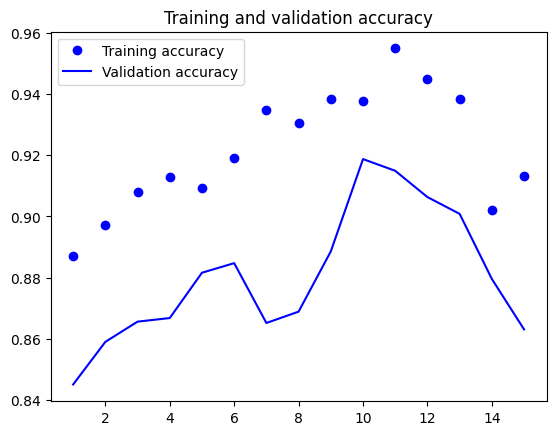

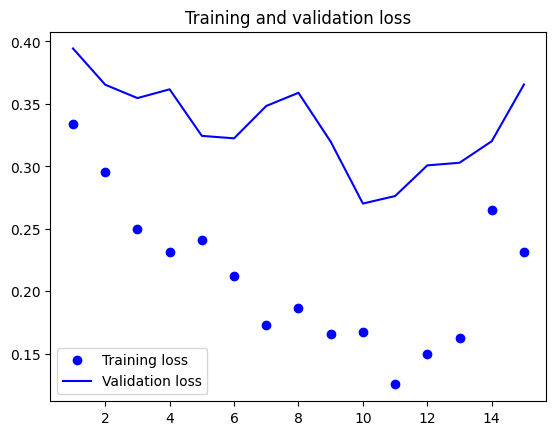

In [25]:
#crtanje grafova za točnost i loss
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
#spremanje istreniranog modela na google drive
from google.colab import files
best_model = tf.keras.models.load_model('upgraded_trained_model')

export_dir = '/content/drive/MyDrive/upgraded_trained_model'
best_model.save(export_dir)
print("Model je spremljen")

Model je spremljen
